In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import pysal.lib.examples as examples
import pysal.lib.weights as weights

import warnings
warnings.filterwarnings('ignore')

import networkx as nx
import access

from geopy.distance import distance,geodesic


GEODATA_PATH = 'data/geodata/'
OUTPUT_PATH = 'data/output/'

c:\users\aldrin\desktop\pyenv\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"


In [2]:
prov_filer = "LANAO DEL SUR"
crs_constant = "EPSG:4326"

brgys_geodata = gpd.read_file(GEODATA_PATH+'AdministrativeBoundariesBARMMBarangays20190206PSA2016/AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp')
brgys_geodata = brgys_geodata.to_crs(crs_constant)

cond = brgys_geodata['Reg_Code']=='PH150000000'
brgys_geodata=brgys_geodata[cond].reset_index(drop=True)

brgys_geodata["centroid"] = brgys_geodata["geometry"].centroid

prov_cond = brgys_geodata["Pro_Name"].str.contains(prov_filer)
brgys_geodata = brgys_geodata[prov_cond].reset_index(drop=True)
print("brgys_geodata",brgys_geodata.shape)

roads_intersects = pd.read_csv(OUTPUT_PATH+'RoadsARMM_OSM2019_Intersects_Clean.csv')
roads_intersects["osm_id"] = roads_intersects["osm_id"].astype(str)

roads_geodata = gpd.read_file(OUTPUT_PATH+'RoadsARMM_OSM2019_Geodata_Clean/RoadsARMM_OSM2019_Geodata_Clean.shp')
roads_geodata = roads_geodata.to_crs(crs_constant)

roads_geodata = roads_geodata.merge(roads_intersects,on="osm_id",how="left")
prov_cond = roads_geodata["PROV_LIST"].str.contains(prov_filer)
roads_geodata = roads_geodata[prov_cond].reset_index(drop=True)
print("roads_geodata",roads_geodata.shape)

schools_geodata = gpd.read_file(OUTPUT_PATH+'SchoolsDepEd2017_Geodata_Clean/SchoolsDepEd2017_Geodata_Clean.shp')
schools_geodata = schools_geodata.to_crs(crs_constant)
schools_geodata.dropna(subset=["PSGC_BRGY"],inplace=True)

cond = (schools_geodata["geometry"].x>0) &(schools_geodata["geometry"].y>0)
schools_geodata = schools_geodata[cond].reset_index(drop=True)

prov_cond = schools_geodata["PROV"].str.contains(prov_filer)
schools_geodata = schools_geodata[prov_cond].reset_index(drop=True)

print("schools_geodata",schools_geodata.shape)

brgys_geodata (1159, 10)
roads_geodata (202, 7)
schools_geodata (888, 13)


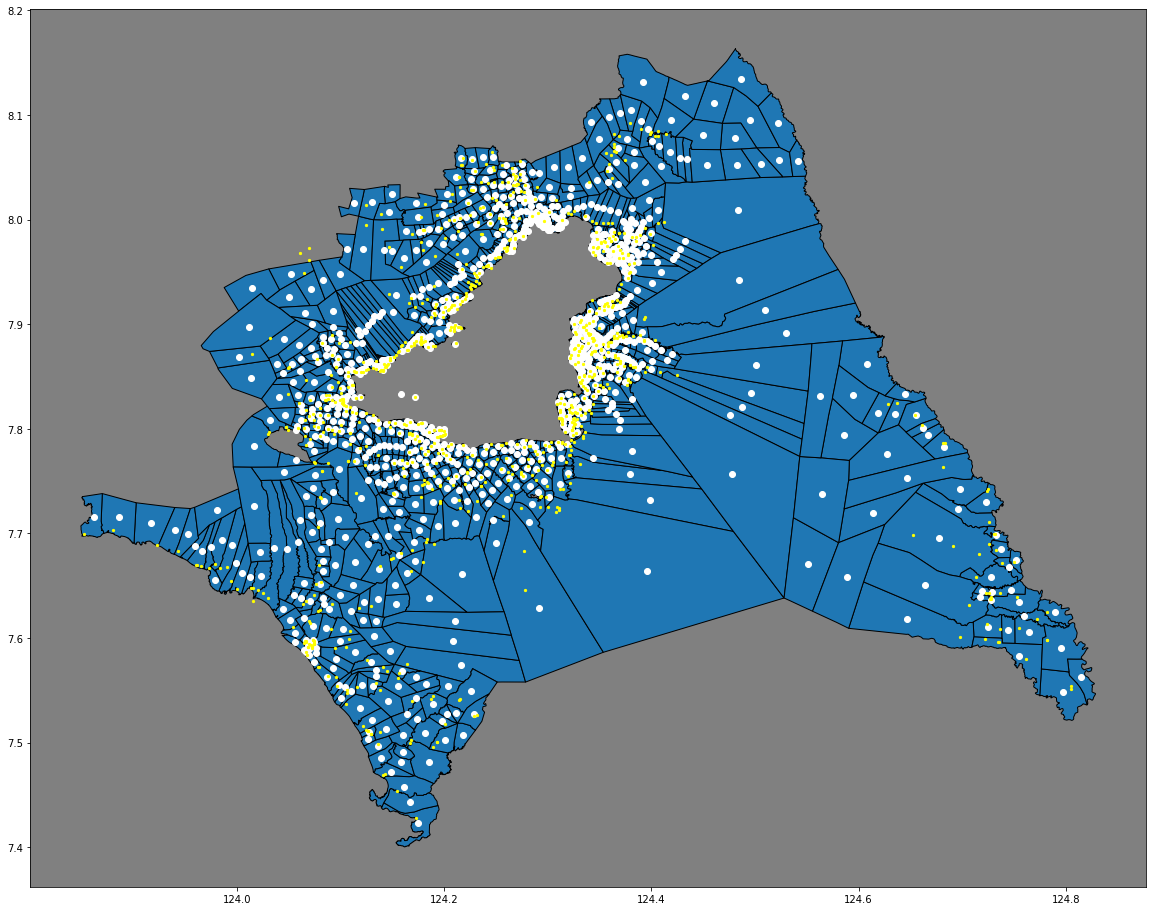

In [3]:
base = brgys_geodata.plot(figsize=(20,20),edgecolor='k')
brgys_geodata["centroid"].plot(ax=base,color="white")
schools_geodata.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

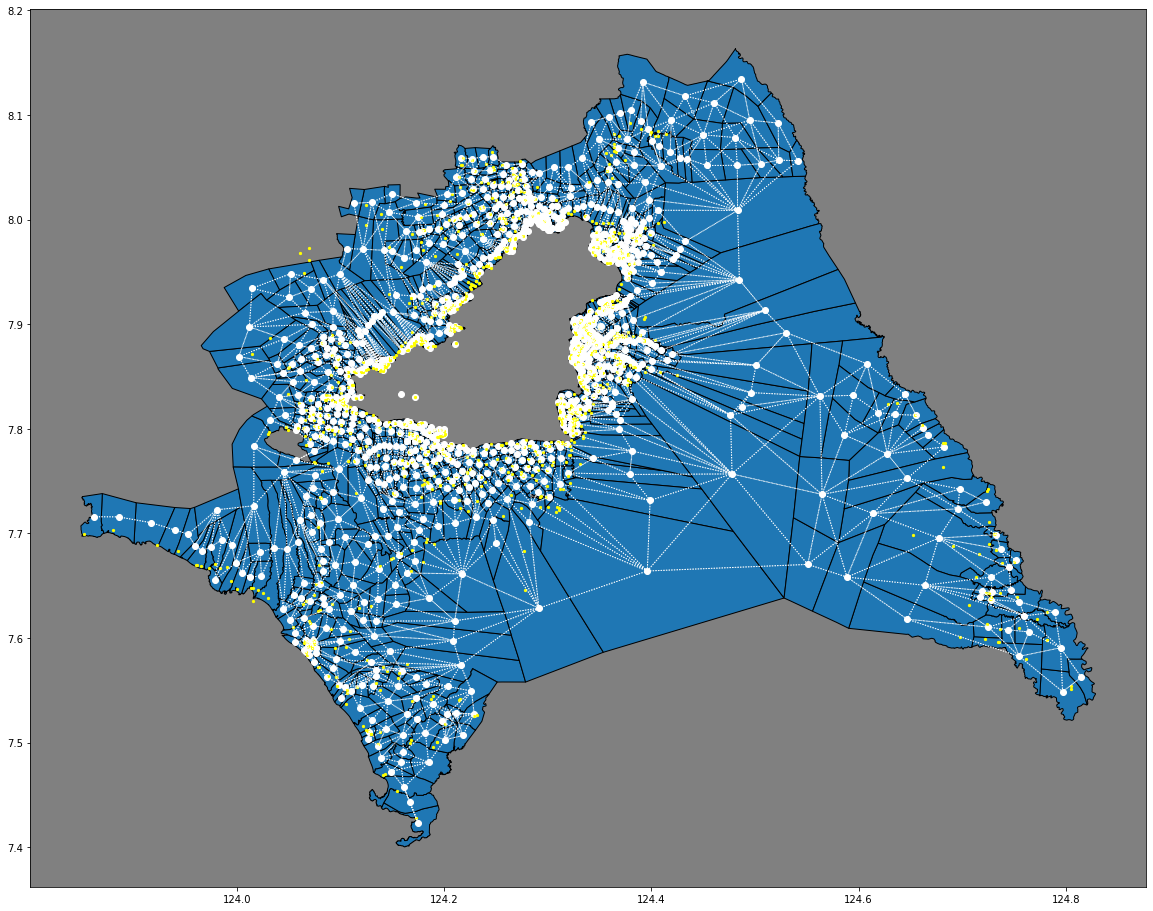

In [4]:
weights_queen = weights.contiguity.Queen.from_dataframe(brgys_geodata)
base = brgys_geodata.plot(figsize=(20,20), edgecolor='k')
weights_queen.plot(brgys_geodata, ax=base, 
        edge_kws=dict(color='white', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
brgys_geodata["centroid"].plot(ax=base,color="white")
schools_geodata.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

In [5]:
def get_PSGC_via_index(index,df,col):
    return df.loc[index,col]

def get_coord_values_in(index,df,col):
    lon = df.loc[index,col].x
    lat = df.loc[index,col].y
    return (lat,lon)

def get_km_dist_two_coord_series(coords1,coords2):
    dists = []
    for coord1,coord2 in zip(coords1,coords2):
        dists.append(geodesic(coord1,coord2).km)
    return dists

In [6]:
weights_nx = weights_queen.to_networkx()
weights_df = nx.to_pandas_edgelist(weights_nx,nodelist=list(weights_nx.nodes))
weights_df.drop(columns="weight",inplace=True)

weights_df["source_PSGC"] = weights_df["source"].apply(get_PSGC_via_index,df=brgys_geodata,col="Bgy_Code")
weights_df["target_PSGC"] = weights_df["target"].apply(get_PSGC_via_index,df=brgys_geodata,col="Bgy_Code")

weights_df["source_coords"] = weights_df["source"].apply(get_coord_values_in,df=brgys_geodata,col="centroid")

psgc_df = weights_df.groupby("source_PSGC",as_index=False)["target_PSGC"].apply(lambda x: "%s" % '|'.join(x))
psgc_df["target_PSGC"] = psgc_df["source_PSGC"]+"|"+psgc_df["target_PSGC"]

schools = schools_geodata[["SCH_ID","PSGC_BRGY","geometry"]]
schools.dropna(subset=["PSGC_BRGY"],inplace=True)
schools.head()

source_target_df = pd.DataFrame()

no_schools_source = []

for source,targets in psgc_df.values:
    cond = schools["PSGC_BRGY"].str.contains(targets)
    
    if (sum(cond))==0:
        no_schools_source.append(source)
        continue
    
    _sub_df = schools[cond]
    _sub_df["source_PSGC"] = source
    source_target_df = source_target_df.append(_sub_df)
    
print(len(no_schools_source),"Brgy with No schools even in neighboring Brgys")
source_target_df = source_target_df.reset_index(drop=True)
source_target_df.head()

90 Brgy with No schools even in neighboring Brgys


,SCH_ID,PSGC_BRGY,geometry,source_PSGC
0,133565,PH153601024,POINT (124.14139 7.85583),PH153601001
1,133553,PH153601026,POINT (124.14230 7.86182),PH153601001
2,133558,PH153601001,POINT (124.14067 7.85648),PH153601001
3,133564,PH153601023,POINT (124.13400 7.86520),PH153601002
4,408948,PH153601019,POINT (124.13897 7.85585),PH153601002


In [7]:
def get_coord_via_PSGC(psgc,df,psgc_col="Bgy_Code",coord_col="centroid"):
    cond = df[psgc_col].str.contains(psgc)
    lon = df.loc[cond,coord_col].x.values[0]
    lat = df.loc[cond,coord_col].y.values[0]
    return (lat,lon)

def to_coord_tuple(point):
    lon = point.x
    lat = point.y
    return (lat,lon)

In [8]:
source_target_df["source_coords"]=source_target_df["source_PSGC"].apply(get_coord_via_PSGC,
                                                                        df=brgys_geodata)

source_target_df["target_coords"] = source_target_df["geometry"].apply(to_coord_tuple)

source_target_df["km_distance"] = get_km_dist_two_coord_series(source_target_df["source_coords"],source_target_df["target_coords"])
source_target_df

,SCH_ID,PSGC_BRGY,geometry,source_PSGC,source_coords,target_coords,km_distance
0,133565,PH153601024,POINT (124.14139 7.85583),PH153601001,"(7.8608079142289276, 124.13929973699351)","(7.855833, 124.141389)",0.596496
1,133553,PH153601026,POINT (124.14230 7.86182),PH153601001,"(7.8608079142289276, 124.13929973699351)","(7.861816, 124.142304)",0.349566
2,133558,PH153601001,POINT (124.14067 7.85648),PH153601001,"(7.8608079142289276, 124.13929973699351)","(7.856479, 124.140669)",0.502006
3,133564,PH153601023,POINT (124.13400 7.86520),PH153601002,"(7.859599749755358, 124.1360409137672)","(7.8652, 124.134)",0.658987
4,408948,PH153601019,POINT (124.13897 7.85585),PH153601002,"(7.859599749755358, 124.1360409137672)","(7.855847222222222, 124.13896666666668)",0.525681
...,...,...,...,...,...,...,...
3323,133681,PH153641006,POINT (124.20386 7.75332),PH153641006,"(7.758971097747426, 124.20110105042004)","(7.753317, 124.203865)",0.695680
3324,133682,PH153641007,POINT (124.19643 7.74580),PH153641006,"(7.758971097747426, 124.20110105042004)","(7.745804, 124.196432)",1.544606
3325,133683,PH153641007,POINT (124.19055 7.75492),PH153641006,"(7.758971097747426, 124.20110105042004)","(7.754924, 124.190551)",1.246856
3326,133684,PH153641009,POINT (124.21163 7.75534),PH153641006,"(7.758971097747426, 124.20110105042004)","(7.755339, 124.211634)",1.229342


In [9]:
cols = ["source_PSGC","SCH_ID","km_distance"]
cost_matrix = source_target_df[cols]
cost_matrix["mins_travel_time"] = 60 * cost_matrix["km_distance"]/1 #km/hour

In [10]:
pop_brgy = pd.read_csv(OUTPUT_PATH+"Population_Schools_SDGs_Clean.csv")
pop_brgy = pop_brgy[["PSGC_BRGY","both_age_13_to_16"]]

brgys = brgys_geodata[["Bgy_Code","geometry"]]
brgys = pd.merge(brgys,pop_brgy,left_on="Bgy_Code",right_on="PSGC_BRGY",how="left")
brgys = brgys[["PSGC_BRGY","geometry","both_age_13_to_16"]]
brgys.head()

,PSGC_BRGY,geometry,both_age_13_to_16
0,PH153601001,"POLYGON ((124.14147 7.85696, 124.14134 7.85685...",65.0
1,PH153601002,"POLYGON ((124.13804 7.85504, 124.13800 7.85505...",53.0
2,PH153601004,"POLYGON ((124.15831 7.83450, 124.15867 7.83446...",56.0
3,PH153601005,"POLYGON ((124.14821 7.87012, 124.14606 7.86785...",80.0
4,PH153601006,"POLYGON ((124.13332 7.86404, 124.13491 7.86056...",54.0


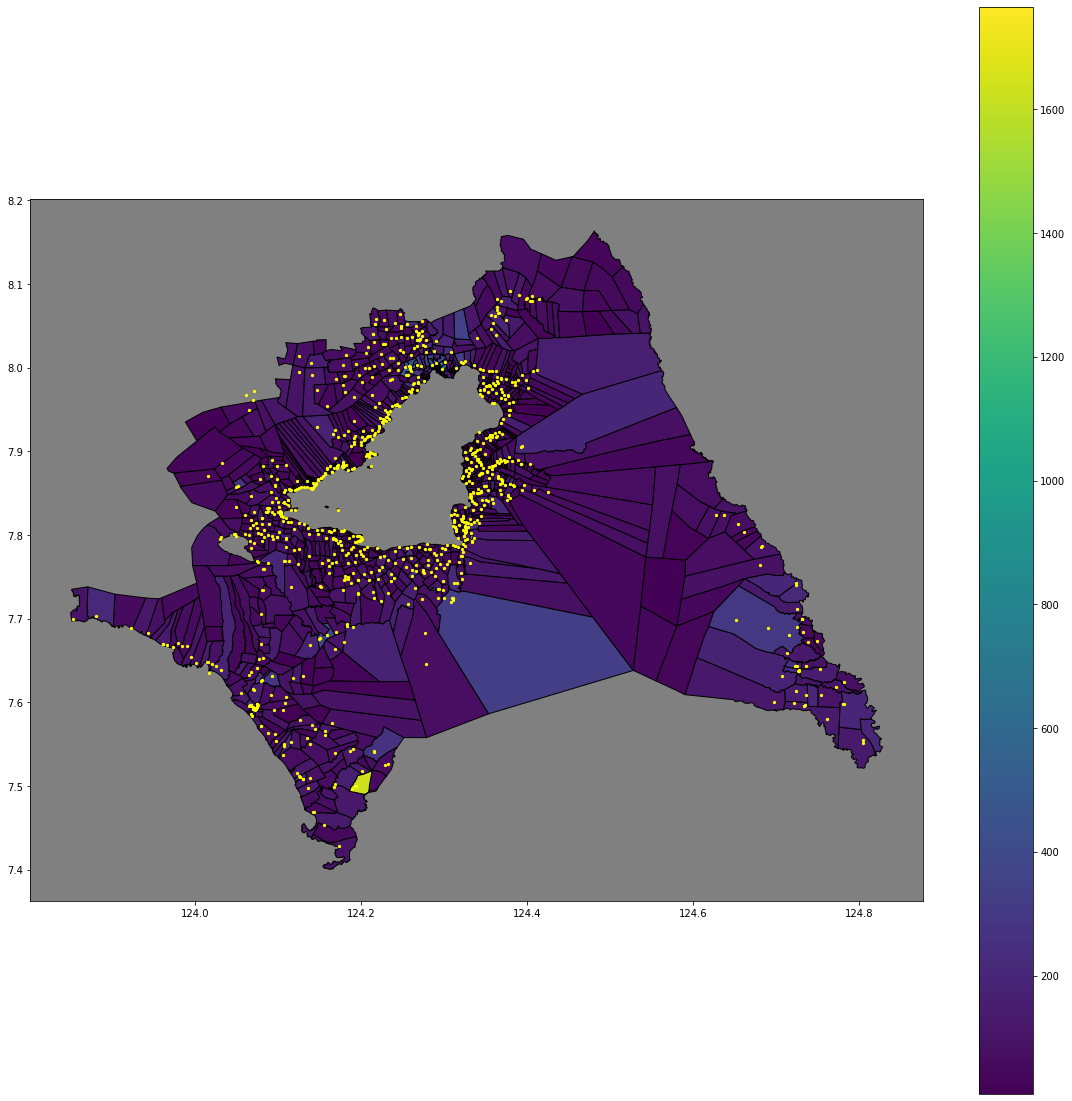

In [11]:
base = brgys.plot(figsize=(20,20),column="both_age_13_to_16",edgecolor='k',legend=True)
schools.plot(ax=base,color="Yellow",markersize = 5)
base.set_facecolor('grey');

In [12]:
brgys_w_schools = gpd.sjoin(schools, brgys[['PSGC_BRGY', 'geometry']],
                                  how='inner', op='intersects')
brgys_w_schools = brgys_w_schools.drop(columns=['index_right',"PSGC_BRGY_right"])
brgys_w_schools = brgys_w_schools.rename(columns={"PSGC_BRGY_left":"PSGC_BRGY"})
brgys_w_schools.head()

,SCH_ID,PSGC_BRGY,geometry
0,133504,PH153627056,POINT (124.34700 7.88034)
1,133212,PH153603001,POINT (124.17913 7.92014)
2,254515,PH153616051,POINT (124.26073 7.97404)
3,133377,PH153618083,POINT (124.32580 7.80593)
4,133367,PH153618052,POINT (124.31569 7.82387)


In [13]:
school_access = access.Access(demand_df    = brgys, 
                                demand_index = 'PSGC_BRGY', 
                                demand_value = 'both_age_13_to_16',
                                supply_df    = brgys_w_schools, 
                                supply_index = 'SCH_ID',
                                cost_df      = cost_matrix, 
                                cost_origin  = 'source_PSGC', 
                                cost_dest    = 'SCH_ID',
                                cost_name    = 'mins_travel_time')

access INFO     :: Warning: A supply value was not provided, so a default
                             supply value of 1 was created in the column named "value".
                             Note that without a supply value, you cannot use any of the
                             floating catchment area methods.


In [14]:
gravity = access.weights.gravity(scale = 60, alpha = -1)
school_access.weighted_catchment(name = "gravity", weight_fn = gravity)

,gravity_value
PSGC_BRGY,
PH153601001,6.529152
PH153601002,9.247157
PH153601004,NaN
PH153601005,2.261653
PH153601006,5.372894
...,...
PH153641005,5.328759
PH153641006,4.362455
PH153641007,NaN


In [15]:
def plot_access_measure(access_metric):
    _map = brgys[["PSGC_BRGY","geometry"]].set_index('PSGC_BRGY').join(school_access.access_df, how = "inner")
    base = _map.plot(access_metric, legend = True, 
                         figsize = (20, 20),  
                         alpha = 1,
                         vmin = _map[access_metric].quantile(0.05), vmax = _map[access_metric].quantile(0.95))
    schools.plot(ax=base, markersize=7, color='yellow')

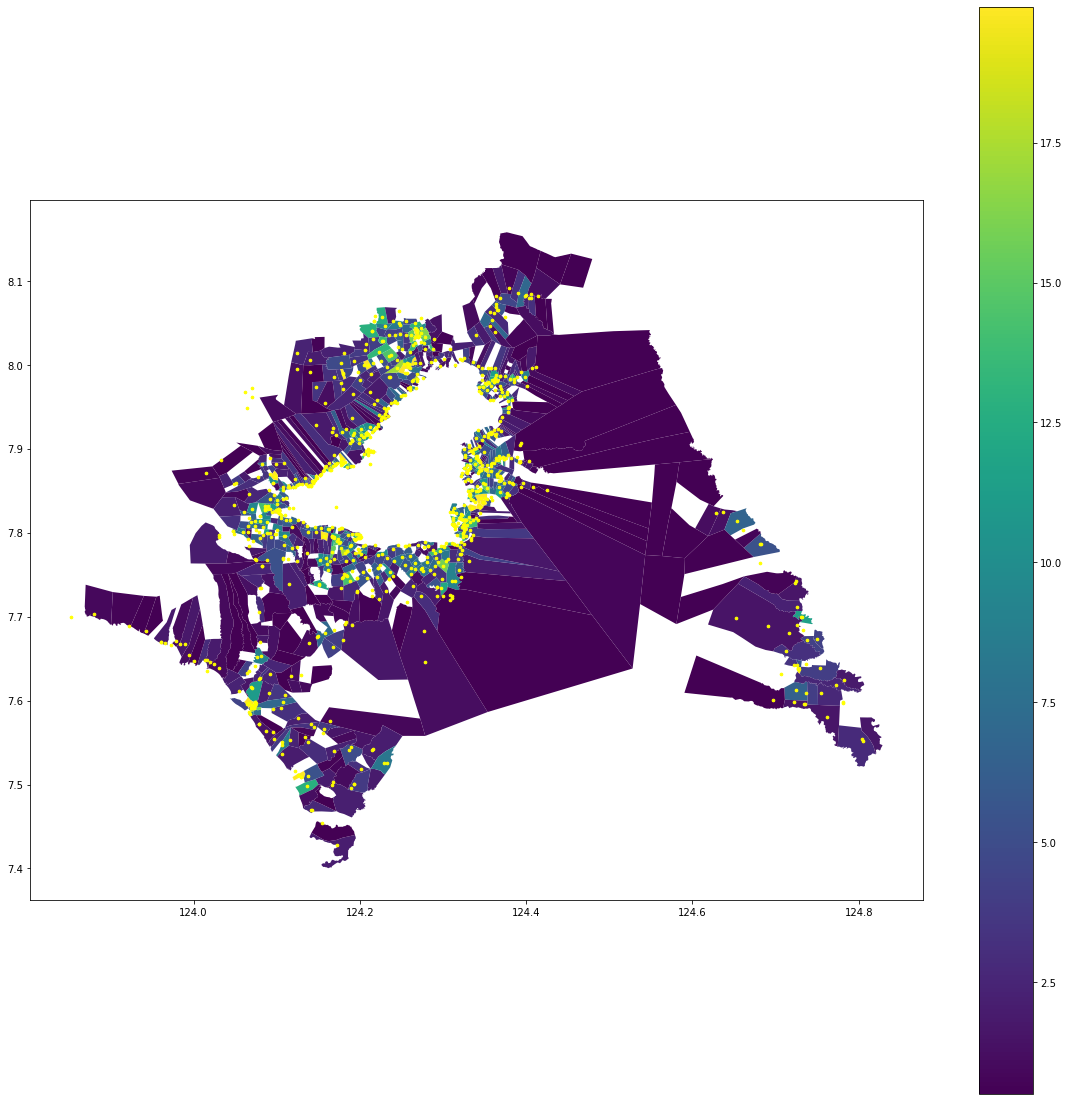

In [16]:
plot_access_measure('gravity_value')

In [17]:
school_access.access_df

,both_age_13_to_16,gravity_value
PSGC_BRGY,,
PH153601001,65.0,6.529152
PH153601002,53.0,9.247157
PH153601004,56.0,NaN
PH153601005,80.0,2.261653
PH153601006,54.0,5.372894
...,...,...
PH153641005,80.0,5.328759
PH153641006,98.0,4.362455
PH153641007,44.0,NaN


In [18]:
school_access.access_df["gravity_value"].describe()

count    881.000000
mean       6.763335
std        9.624879
min        0.071367
25%        1.843273
50%        4.215185
75%        8.101960
max      121.231753
Name: gravity_value, dtype: float64